# Adaptive exponential IF model
The differential equations governing the neuron model are as follows:

$$
\tau_m \frac{dV(t)}{dt} = -(V(t) - E_L) + D \exp\left(\frac{V(t) - V_T}{D}\right) + I_x(t) - w(t)
$$

$$
\tau_w \frac{dw(t)}{dt} = -w(t) + a(V(t) - E_L)
$$

The spike-triggered reset conditions are:

$$
\quad \text{if} \quad V(t) \geq V_{th} , \text{spike and reset } V(t) = V_{re}, and \quad w(t) = w(t) + b 
$$
- a governs the subtheshold adaptation dynamics



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[ 0.00000000e+00  0.00000000e+00 -8.33334847e-08 ... -1.03287479e+01
 -1.03290050e+01 -1.03292622e+01]


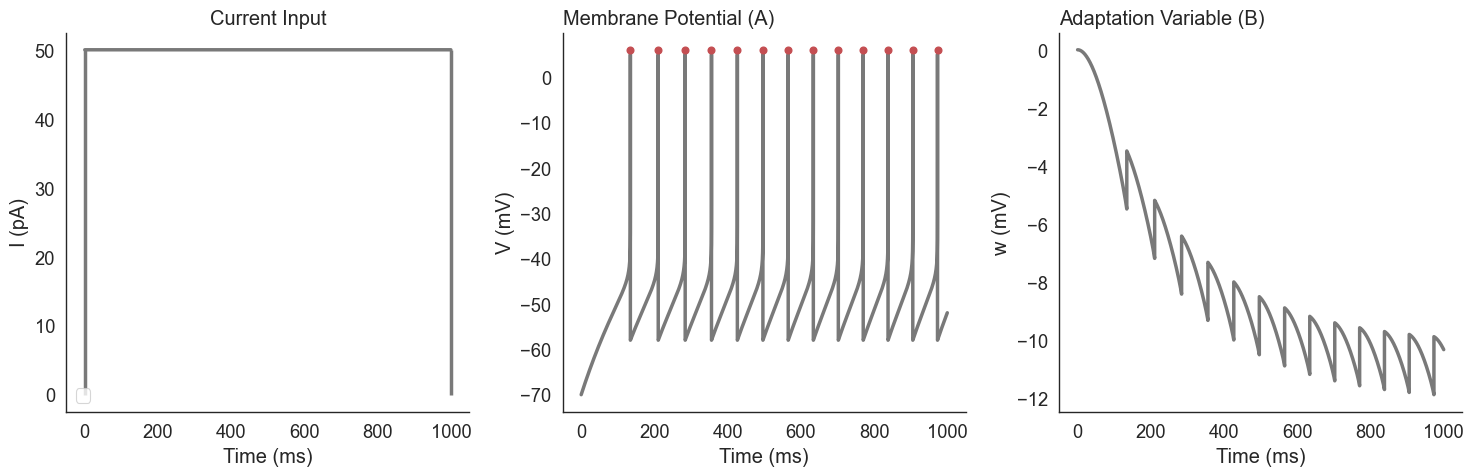

In [52]:
import numpy as np
# Discretized time
T = 1000
dt = .01
time = np.arange(0, T, dt)

# Applied current
Ix = np.zeros_like(time) + 50

# Neuron parameters (AdEx model)
EL = -70  # Resting membrane potential (v_rest)
taum = 200  # Membrane time constant (tau_m)
Vth = 5  # Firing threshold (v_spike)
Vre = -58  # Reset potential (v_reset)
VT = -50  # Rheobase threshold (v_rheobase)
D = 2  # Sharpness of exponential term (delta_T)
gL = 12  # Membrane conductance
a = -1  # Adaptation-voltage coupling
b = 2  # Spike-triggered adaptation increment
tauw = 300  # Adaptation time constant (tau_w)
C = 200  # Membrane capacitance (optional, depends on formulation)

# Initial condition
V0 = EL
V = np.zeros_like(time)
w = np.zeros_like(time)
SpikeTimes = np.array([])
V[0] = V0
w[0] = 0

# Compute V using the forward Euler method
for i in range(len(time) - 1):

    # Euler step for the membrane potential V
    V[i+1] = V[i] + dt * (-(V[i] - EL) + D * np.exp((V[i] - VT) / D) + Ix[i] - w[i]) / taum

    # Euler step for the adaptation variable w
    w[i+1] = w[i] + dt * (a * (V[i] - EL) - w[i]) / tauw

    # Threshold-reset condition
    if V[i+1] >= Vth:
        V[i+1] = Vre  # Reset voltage after spike
        w[i+1] += b  # Increase adaptation variable
        V[i] = Vth  # Set to threshold for aesthetic in the plot
        SpikeTimes = np.append(SpikeTimes, time[i+1])

# Make figure
plt.subplots(1, 3, figsize=(15, 5))

# First subplot: Plot the current input with vertical lines indicating the current start and end
plt.subplot(1, 3, 1)
plt.plot(time, Ix, color=sns.color_palette()[7])
plt.vlines(x=time[0], ymin=0, ymax=Ix[0], color=sns.color_palette()[7])
plt.vlines(x=time[-1], ymin=0, ymax=Ix[-1], color=sns.color_palette()[7])
plt.title('Current Input')
plt.xlabel('Time (ms)')
plt.ylabel('I (pA)')
plt.legend()
sns.despine()

# Second subplot: Plot the membrane potential V
plt.subplot(1, 3, 2)
plt.plot(time, V, color=sns.color_palette()[7])
plt.plot(SpikeTimes, Vth + 1 + 0 * SpikeTimes, 'ro')
plt.xlabel('Time (ms)')
plt.ylabel('V (mV)')
sns.despine()
plt.title('Membrane Potential (A)', loc='left')

# Third subplot: Plot the adaptation variable w
plt.subplot(1, 3, 3)
plt.plot(time, w, color=sns.color_palette()[7])
plt.xlabel('Time (ms)')
plt.ylabel('w (mV)')
sns.despine()
plt.title('Adaptation Variable (B)', loc='left')

plt.tight_layout()

# Print the adaptation variable w
print(w)




WARNING    Cannot use Cython, a test compilation failed: Unable to find vcvarsall.bat (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]
WARNING    'i' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value 9998. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'w' is an internal variable of group 'neurongroup', but also exists in the run namespace with the value array([0.00000000e+00, 5.00000000e-05, 1.02821018e-04, ...,
       3.62142243e+00, 3.62090913e+00, 3.62039609e+00]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


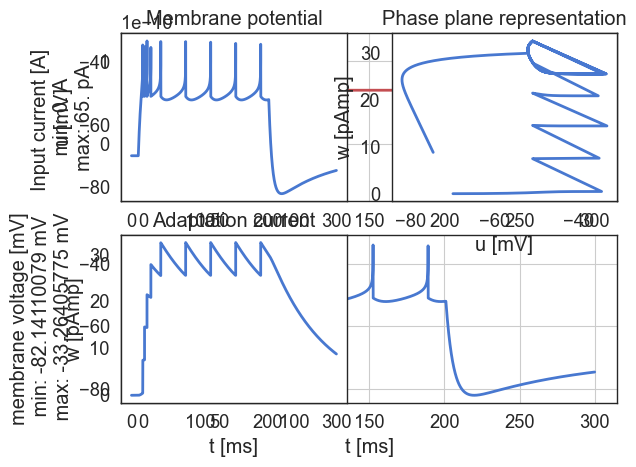

nr of spikes: 9


In [5]:
"""
Implementation of the Adaptive Exponential Integrate-and-Fire model.

See Neuronal Dynamics
`Chapter 6 Section 1 <http://neuronaldynamics.epfl.ch/online/Ch6.S1.html>`_

"""

# This file is part of the exercise code repository accompanying
# the book: Neuronal Dynamics (see http://neuronaldynamics.epfl.ch)
# located at http://github.com/EPFL-LCN/neuronaldynamics-exercises.

# This free software: you can redistribute it and/or modify it under
# the terms of the GNU General Public License 2.0 as published by the
# Free Software Foundation. You should have received a copy of the
# GNU General Public License along with the repository. If not,
# see http://www.gnu.org/licenses/.

# Should you reuse and publish the code for your own purposes,
# please cite the book or point to the webpage http://neuronaldynamics.epfl.ch.

# Wulfram Gerstner, Werner M. Kistler, Richard Naud, and Liam Paninski.
# Neuronal Dynamics: From Single Neurons to Networks and Models of Cognition.
# Cambridge University Press, 2014.

import brian2 as b2
import matplotlib.pyplot as plt
import neurodynex3.tools.input_factory as input_factory

b2.defaultclock.dt = 0.01 * b2.ms

# default values. (see Table 6.1, Initial Burst)
# http://neuronaldynamics.epfl.ch/online/Ch6.S2.html#Ch6.F3
MEMBRANE_TIME_SCALE_tau_m = 5 * b2.ms
MEMBRANE_RESISTANCE_R = 500 * b2.Mohm
V_REST = -70.0 * b2.mV
V_RESET = -51.0 * b2.mV
RHEOBASE_THRESHOLD_v_rh = -50.0 * b2.mV
SHARPNESS_delta_T = 2.0 * b2.mV
ADAPTATION_VOLTAGE_COUPLING_a = 0.5 * b2.nS
ADAPTATION_TIME_CONSTANT_tau_w = 100.0 * b2.ms
SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b = 7.0 * b2.pA

# a technical threshold to tell the algorithm when to reset vm to v_reset
FIRING_THRESHOLD_v_spike = -30. * b2.mV


# This function implement Adaptive Exponential Leaky Integrate-And-Fire neuron model
def simulate_AdEx_neuron(
        tau_m=MEMBRANE_TIME_SCALE_tau_m,
        R=MEMBRANE_RESISTANCE_R,
        v_rest=V_REST,
        v_reset=V_RESET,
        v_rheobase=RHEOBASE_THRESHOLD_v_rh,
        a=ADAPTATION_VOLTAGE_COUPLING_a,
        b=SPIKE_TRIGGERED_ADAPTATION_INCREMENT_b,
        v_spike=FIRING_THRESHOLD_v_spike,
        delta_T=SHARPNESS_delta_T,
        tau_w=ADAPTATION_TIME_CONSTANT_tau_w,
        I_stim=input_factory.get_zero_current(),
        simulation_time=200 * b2.ms):
    r"""
    Implementation of the AdEx model with a single adaptation variable w.

    The Brian2 model equations are:

    .. math::

        \tau_m \frac{dv}{dt} = -(v-v_{rest}) + \Delta_T \cdot
                                e^{\frac{v-v_{rheobase}}{\Delta_T}} + R I_{stim}(t,i) - R w \\
        \tau_w \frac{dw}{dt} = a (v-v_{rest}) - w

    Args:
        tau_m (Quantity): membrane time scale
        R (Quantity): membrane restistance
        v_rest (Quantity): resting potential
        v_reset (Quantity): reset potential
        v_rheobase (Quantity): rheobase threshold
        a (Quantity): Adaptation-Voltage coupling
        b (Quantity): Spike-triggered adaptation current (=increment of w after each spike)
        v_spike (Quantity): voltage threshold for the spike condition
        delta_T (Quantity): Sharpness of the exponential term
        tau_w (Quantity): Adaptation time constant
        I_stim (TimedArray): Input current
        simulation_time (Quantity): Duration for which the model is simulated

    Returns:
        (state_monitor, spike_monitor):
        A b2.StateMonitor for the variables "v" and "w" and a b2.SpikeMonitor
    """

    v_spike_str = "v>{:f}*mvolt".format(v_spike / b2.mvolt)

    # EXP-IF
    eqs = """
        dv/dt = (-(v-v_rest) +delta_T*exp((v-v_rheobase)/delta_T)+ R * I_stim(t,i) - R * w)/(tau_m) : volt
        dw/dt=(a*(v-v_rest)-w)/tau_w : amp
        """

    neuron = b2.NeuronGroup(1, model=eqs, threshold=v_spike_str, reset="v=v_reset;w+=b", method="euler")

    # initial values of v and w is set here:
    neuron.v = v_rest
    neuron.w = 0.0 * b2.pA

    # Monitoring membrane voltage (v) and w
    state_monitor = b2.StateMonitor(neuron, ["v", "w"], record=True)
    spike_monitor = b2.SpikeMonitor(neuron)

    # running simulation
    b2.run(simulation_time)
    return state_monitor, spike_monitor


def plot_adex_state(adex_state_monitor):
    """
    Visualizes the state variables: w-t, v-t and phase-plane w-v

    Args:
    adex_state_monitor (StateMonitor): States of "v" and "w"
    """
    plt.subplot(2, 2, 1)
    plt.plot(adex_state_monitor.t / b2.ms, adex_state_monitor.v[0] / b2.mV, lw=2)
    plt.xlabel("t [ms]")
    plt.ylabel("u [mV]")
    plt.title("Membrane potential")
    plt.subplot(2, 2, 2)
    plt.plot(adex_state_monitor.v[0] / b2.mV, adex_state_monitor.w[0] / b2.pA, lw=2)
    plt.xlabel("u [mV]")
    plt.ylabel("w [pAmp]")
    plt.title("Phase plane representation")
    plt.subplot(2, 2, 3)
    plt.plot(adex_state_monitor.t / b2.ms, adex_state_monitor.w[0] / b2.pA, lw=2)
    plt.xlabel("t [ms]")
    plt.ylabel("w [pAmp]")
    plt.title("Adaptation current")
    plt.show()


def getting_started():
    """
    Simple example to get started
    """

    from neurodynex3.tools import plot_tools
    current = input_factory.get_step_current(10, 200, 1. * b2.ms, 65.0 * b2.pA)
    state_monitor, spike_monitor = simulate_AdEx_neuron(I_stim=current, simulation_time=300 * b2.ms)
    plot_tools.plot_voltage_and_current_traces(state_monitor, current)
    plot_adex_state(state_monitor)
    print("nr of spikes: {}".format(spike_monitor.count[0]))


if __name__ == "__main__":
    getting_started()

nr of spikes: 10


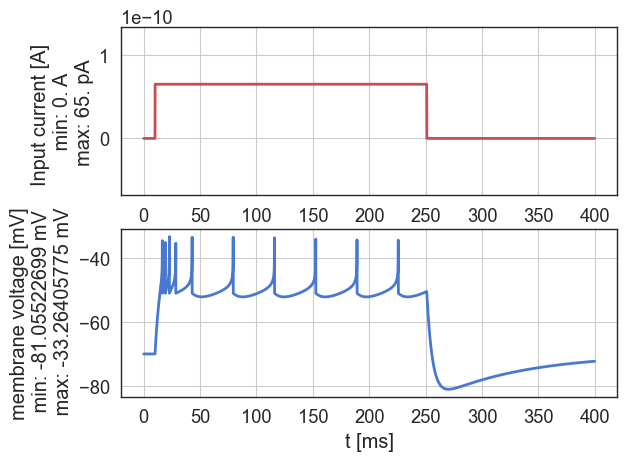

In [6]:
%matplotlib inline
import brian2 as b2
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import plot_tools, input_factory

current = input_factory.get_step_current(10, 250, 1. * b2.ms, 65.0 * b2.pA)
state_monitor, spike_monitor = AdEx.simulate_AdEx_neuron(I_stim=current, simulation_time=400 * b2.ms)
plot_tools.plot_voltage_and_current_traces(state_monitor, current)
print("nr of spikes: {}".format(spike_monitor.count[0]))
# AdEx.plot_adex_state(state_monitor)
